In [1]:
import json
import tqdm
import re
import os

import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt

In [2]:
if not os.path.exists("output.ndjson"):
    with open("output.ndjson", "w") as output:
        for dirpath, dirnames, filenames in tqdm.tqdm(os.walk('dump'), total=258):
            for filename in filenames:
                file_path = os.path.join(dirpath, filename)
                hash_value = file_path.replace('dump/github-content-2023-10-23/', '').replace('/', '').replace('.json', '')

                if 'gstmp' in filename:
                    continue
                
                with open(file_path) as f:
                    try: 
                        data = json.loads(f.read())
                        data[0]['hash'] = hash_value
                        output.write(json.dumps(data) + '\n')
                    except Exception:
                        print(f"Failed to read {filename}")


In [3]:
with open('output.ndjson') as f:
    data = [json.loads(line) for line in tqdm.tqdm(f.readlines())]
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 569382/569382 [00:10<00:00, 54225.44it/s]


In [4]:
def get_size(point):
    cap = 20000
    if len(point) == 2:
        code_size = min(len(point[1]['content']), cap)
        readme_size = min(len(point[0]['content']), cap)
    else:
        code_size = min(len(point[0]['content']), cap)
        readme_size = 0

    return [code_size, readme_size]

code_sizes = np.array([get_size(d)[0] for d in data])
readme_sizes = np.array([get_size(d)[1] for d in data])

In [5]:
def render_histogram(data, title):
    bucket_size = 50
    bins = np.linspace(math.ceil(min(data)), 
                       math.floor(max(data)),
                       bucket_size) # fixed number of bins
    
    plt.xlim([min(data)-5, max(data)+5])
    
    plt.hist(data, bins=bins, alpha=0.5)
    plt.title(f'{title} size (fixed number of bins)')
    plt.xlabel(f'variable X ({bucket_size} evenly spaced bins)')
    plt.ylabel('count')
    
    plt.show()

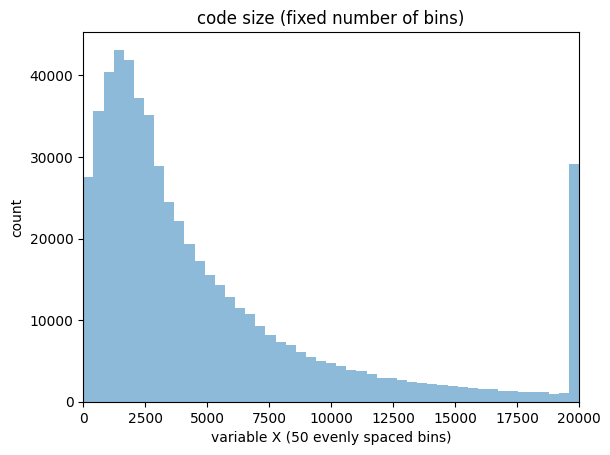

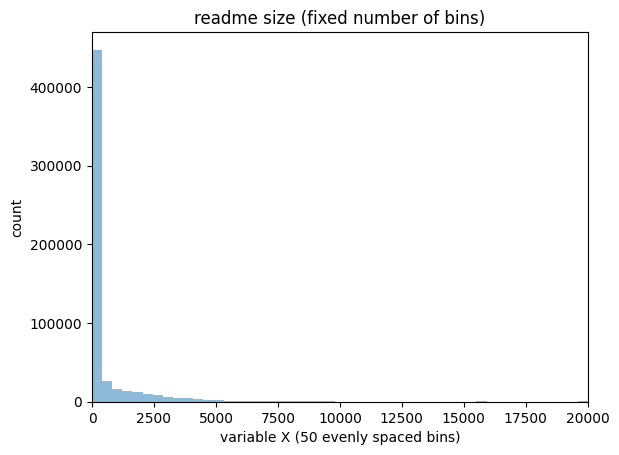

In [6]:
render_histogram(code_sizes, "code")
render_histogram(readme_sizes, "readme")

In [7]:
# clean data
import_pattern = re.compile(r'^\s*(?:import|from)\s+([a-zA-Z0-9_\.]+)', re.MULTILINE)
streamlit_pattern = re.compile(r'st\.([a-zA-Z_][a-zA-Z0-9_]*)\s*\([^()]*(?:\([^()]*\)[^()]*)*\)', re.MULTILINE)
title_patterns = [
    r'st\.set_page_config\s*\(\s*page_title\s*=\s*["\']([^"\']+)["\']',
    r'st\.title\s*\(\s*["\']([^"\']+)["\']',
    r'st\.header\s*\(\s*["\']([^"\']+)["\']'
]


def split_long_line(line, max_chars):
    segments = []
    start = 0
    while start < len(line):
        if len(line) - start <= max_chars:
            segments.append(line[start:])
            break
        break_point = line.rfind(' ', start, start + max_chars)
        if break_point == -1 or break_point == start:
            break_point = start + max_chars
        segments.append(line[start:break_point].rstrip() + "\n")
        start = break_point
        while start < len(line) and line[start] == ' ':
            start += 1
    return segments


def split_text_into_chunks(text, max_tokens=512, avg_chars_per_token=4):
    max_chars = max_tokens * avg_chars_per_token  # e.g. 2048 * 4 = 8192 characters
    lines = text.splitlines(keepends=True)
    
    chunks = []
    current_chunk = ""
    current_length = 0

    for line in lines:
        if len(line) > max_chars:
            segments = split_long_line(line, max_chars)
            for seg in segments:
                if current_length + len(seg) > max_chars:
                    if current_chunk:
                        chunks.append(current_chunk)
                        current_chunk = ""
                        current_length = 0
                current_chunk += seg
                current_length += len(seg)
        else:
            if current_length + len(line) > max_chars:
                if current_chunk:
                    chunks.append(current_chunk)
                    current_chunk = ""
                    current_length = 0
            current_chunk += line
            current_length += len(line)

    if current_chunk:
        chunks.append(current_chunk)

    return chunks


def split_point(point):
    if len(point) == 2:
        return point[1], point[0]
    return point[0], {}

def generate_dependencies(code):
    imports = set(match.group(1) for match in import_pattern.finditer(code['content']))
    
    return list(imports)
            
def streamlit_components(code):
    components = set(match.group(1) for match in streamlit_pattern.finditer(code['content']))
    return list(components)


def extract_streamlit_title(code):
    for pattern in title_patterns:
        match = re.search(pattern, code['content'])
        if match:
            return match.group(1)
            
    return ""

def prepare_data(point):
    content_limit = 30000
    hash_value = point[0]['hash']
    code, readme = split_point(point)
    chunks = split_text_into_chunks(code['content'][:content_limit])
    
    if readme.get('content'):
        chunks += split_text_into_chunks(code['content'][:content_limit])

    return {
        "chunks": chunks,
        "title": extract_streamlit_title(code),
        "hash": hash_value,
        "dependencies": generate_dependencies(code),
        "components": streamlit_components(code),
    }
     

df = pd.DataFrame(prepare_data(d) for d in tqdm.tqdm(data))
df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 569382/569382 [01:25<00:00, 6680.66it/s]


,chunks,title,hash,dependencies,components
0,[\nimport streamlit as st\nimport pickle\nimpo...,Salary Prediction App,616d419c459148f94bea842f3b3ee614d80addf16a845b...,"[numpy, streamlit, pickle]","[number_input, write, title, selectbox]"
1,[import streamlit as st\nimport sqlalchemy\nim...,Carbon Negative Solution,61963187a37e4576c5f8388f8cbc94b4d7ac0c6b9f20f0...,"[PIL, streamlit_shadcn_ui, pandas, sqlalchemy,...","[columns, subheader, line_chart, connection, s..."
2,[\nimport streamlit as st\nimport openai\n\n# ...,My OT AI Assistant,61052f0baaa299298155ebe501c0c51a9423ee3fc60781...,"[streamlit, openai]","[text_input, write, title]"
3,[import streamlit as st\n\nfrom PIL import Ima...,Audio-Wikipedia,61f759168156dbbc44e325ee4419c83d92ccbbb6ab7ef8...,"[streamlit, PIL]","[selectbox, text_input, write, header, audio, ..."
4,[import streamlit as st\nst.set_page_config(pa...,ML Web App: Intro/Summary,61dd5e3734a1ea12b799e444efd4fe3c36ac2603953911...,"[PIL, streamlit, streamlit_lottie, requests]","[columns, subheader, container, set_page_confi..."
...,...,...,...,...,...
569377,[import streamlit as st\n\nst.set_page_config(...,FullstackGPT Home,2532e0b4101daef09d14cdc62215e5eb6c12458b99723a...,[streamlit],"[set_page_config, markdown]"
569378,[import streamlit as st\r\nfrom streamlit_extr...,,25c67899118a53f5a559d3448c4166580a41eda4633a21...,"[streamlit_extras.switch_page_button, streamli...","[columns, caption, markdown, set_page_config, ..."
569379,[import matplotlib.pyplot as plt\nimport seabo...,Always Her Spotify Stats,25cbd56607f439e888fc03e8a212ec3914ec8c09720b64...,"[numpy, os, matplotlib.pyplot, pandas, streaml...","[columns, tabs, subheader, date_input, line_ch..."
569380,[import requests\nimport json\nimport time\nim...,,25532eb96a783016448bcc06942d27675798e612fd7a96...,"[requests, time, os, sys, socketserver, platfo...",[]


In [8]:
index = pd.read_json("tables/app_index.json", lines=True)
df_search_index = index[(index['pinecone_index'] == 'prod-ada-v2-2023-10-23')]
df_search_index = df_search_index[df_search_index['status'] == 5]

df_with_index = pd.merge(df, df_search_index[['app_id', 'hash']], on='hash', how='left')
df_with_index

,chunks,title,hash,dependencies,components,app_id
0,[\nimport streamlit as st\nimport pickle\nimpo...,Salary Prediction App,616d419c459148f94bea842f3b3ee614d80addf16a845b...,"[numpy, streamlit, pickle]","[number_input, write, title, selectbox]",a7a58c77-95df-4dcb-a9e8-54cfa580f3a9
1,[import streamlit as st\nimport sqlalchemy\nim...,Carbon Negative Solution,61963187a37e4576c5f8388f8cbc94b4d7ac0c6b9f20f0...,"[PIL, streamlit_shadcn_ui, pandas, sqlalchemy,...","[columns, subheader, line_chart, connection, s...",46cabca1-c88d-4a6e-a35e-bf40180c3b0d
2,[\nimport streamlit as st\nimport openai\n\n# ...,My OT AI Assistant,61052f0baaa299298155ebe501c0c51a9423ee3fc60781...,"[streamlit, openai]","[text_input, write, title]",7ab8441f-279c-4cf0-97ed-1785b41037b4
3,[import streamlit as st\n\nfrom PIL import Ima...,Audio-Wikipedia,61f759168156dbbc44e325ee4419c83d92ccbbb6ab7ef8...,"[streamlit, PIL]","[selectbox, text_input, write, header, audio, ...",3dfb8032-4077-4fda-9347-26a896ca6f68
4,[import streamlit as st\nst.set_page_config(pa...,ML Web App: Intro/Summary,61dd5e3734a1ea12b799e444efd4fe3c36ac2603953911...,"[PIL, streamlit, streamlit_lottie, requests]","[columns, subheader, container, set_page_confi...",d197ea3c-279f-49eb-817d-2e17819efb34
...,...,...,...,...,...,...
569377,[import streamlit as st\n\nst.set_page_config(...,FullstackGPT Home,2532e0b4101daef09d14cdc62215e5eb6c12458b99723a...,[streamlit],"[set_page_config, markdown]",e16c0953-1b25-4f34-9097-c90154f9f12c
569378,[import streamlit as st\r\nfrom streamlit_extr...,,25c67899118a53f5a559d3448c4166580a41eda4633a21...,"[streamlit_extras.switch_page_button, streamli...","[columns, caption, markdown, set_page_config, ...",d66b85ff-5c40-4955-a393-7bccbd8329aa
569379,[import matplotlib.pyplot as plt\nimport seabo...,Always Her Spotify Stats,25cbd56607f439e888fc03e8a212ec3914ec8c09720b64...,"[numpy, os, matplotlib.pyplot, pandas, streaml...","[columns, tabs, subheader, date_input, line_ch...",NaN
569380,[import requests\nimport json\nimport time\nim...,,25532eb96a783016448bcc06942d27675798e612fd7a96...,"[requests, time, os, sys, socketserver, platfo...",[],1fe1fd05-3e5c-45c7-8198-4471f992d390


In [9]:
app_views = pd.read_json("tables/app_views.json", lines=True)
df_with_views = pd.merge(df_with_index, app_views, on='app_id', how='inner')

df_with_views

,chunks,title,hash,dependencies,components,app_id,unique_views,recent_unique_views
0,[\nimport streamlit as st\nimport pickle\nimpo...,Salary Prediction App,616d419c459148f94bea842f3b3ee614d80addf16a845b...,"[numpy, streamlit, pickle]","[number_input, write, title, selectbox]",a7a58c77-95df-4dcb-a9e8-54cfa580f3a9,5,1
1,[import streamlit as st\nimport sqlalchemy\nim...,Carbon Negative Solution,61963187a37e4576c5f8388f8cbc94b4d7ac0c6b9f20f0...,"[PIL, streamlit_shadcn_ui, pandas, sqlalchemy,...","[columns, subheader, line_chart, connection, s...",46cabca1-c88d-4a6e-a35e-bf40180c3b0d,3,1
2,[\nimport streamlit as st\nimport openai\n\n# ...,My OT AI Assistant,61052f0baaa299298155ebe501c0c51a9423ee3fc60781...,"[streamlit, openai]","[text_input, write, title]",7ab8441f-279c-4cf0-97ed-1785b41037b4,1,0
3,[import streamlit as st\n\nfrom PIL import Ima...,Audio-Wikipedia,61f759168156dbbc44e325ee4419c83d92ccbbb6ab7ef8...,"[streamlit, PIL]","[selectbox, text_input, write, header, audio, ...",3dfb8032-4077-4fda-9347-26a896ca6f68,18,0
4,[import streamlit as st\nst.set_page_config(pa...,ML Web App: Intro/Summary,61dd5e3734a1ea12b799e444efd4fe3c36ac2603953911...,"[PIL, streamlit, streamlit_lottie, requests]","[columns, subheader, container, set_page_confi...",d197ea3c-279f-49eb-817d-2e17819efb34,5,1
...,...,...,...,...,...,...,...,...
500676,[import streamlit as st\nimport streamlit_auth...,Dashboard,25b596ddac0f655fdb3c51e23f6e9be110d1cc986be190...,"[streamlit_authenticator, users, os, streamlit...","[file_uploader, error, button, experimental_re...",b288ba78-de80-401f-821d-54d55492188f,3,1
500677,[import streamlit as st\n\nst.set_page_config(...,FullstackGPT Home,2532e0b4101daef09d14cdc62215e5eb6c12458b99723a...,[streamlit],"[set_page_config, markdown]",e16c0953-1b25-4f34-9097-c90154f9f12c,1,1
500678,[import streamlit as st\r\nfrom streamlit_extr...,,25c67899118a53f5a559d3448c4166580a41eda4633a21...,"[streamlit_extras.switch_page_button, streamli...","[columns, caption, markdown, set_page_config, ...",d66b85ff-5c40-4955-a393-7bccbd8329aa,16,1
500679,[import requests\nimport json\nimport time\nim...,,25532eb96a783016448bcc06942d27675798e612fd7a96...,"[requests, time, os, sys, socketserver, platfo...",[],1fe1fd05-3e5c-45c7-8198-4471f992d390,1,1


In [10]:
apps = pd.read_json("tables/apps.json", lines=True)
apps['app_id'] = apps['id']

merged_df = pd.merge(df_with_views, apps[['app_id', 'owner', "repository"]],  on='app_id', how='inner')
merged_df

,chunks,title,hash,dependencies,components,app_id,unique_views,recent_unique_views,owner,repository
0,[\nimport streamlit as st\nimport pickle\nimpo...,Salary Prediction App,616d419c459148f94bea842f3b3ee614d80addf16a845b...,"[numpy, streamlit, pickle]","[number_input, write, title, selectbox]",a7a58c77-95df-4dcb-a9e8-54cfa580f3a9,5,1,dishachauhan32,hrdisharepo1
1,[import streamlit as st\nimport sqlalchemy\nim...,Carbon Negative Solution,61963187a37e4576c5f8388f8cbc94b4d7ac0c6b9f20f0...,"[PIL, streamlit_shadcn_ui, pandas, sqlalchemy,...","[columns, subheader, line_chart, connection, s...",46cabca1-c88d-4a6e-a35e-bf40180c3b0d,3,1,kyungminlee-12,cns_int
2,[\nimport streamlit as st\nimport openai\n\n# ...,My OT AI Assistant,61052f0baaa299298155ebe501c0c51a9423ee3fc60781...,"[streamlit, openai]","[text_input, write, title]",7ab8441f-279c-4cf0-97ed-1785b41037b4,1,0,usa-cyclist,openai_api_bot_ot2
3,[import streamlit as st\n\nfrom PIL import Ima...,Audio-Wikipedia,61f759168156dbbc44e325ee4419c83d92ccbbb6ab7ef8...,"[streamlit, PIL]","[selectbox, text_input, write, header, audio, ...",3dfb8032-4077-4fda-9347-26a896ca6f68,18,0,rizmehdi,cpcoursebrixen
4,[import streamlit as st\nst.set_page_config(pa...,ML Web App: Intro/Summary,61dd5e3734a1ea12b799e444efd4fe3c36ac2603953911...,"[PIL, streamlit, streamlit_lottie, requests]","[columns, subheader, container, set_page_confi...",d197ea3c-279f-49eb-817d-2e17819efb34,5,1,phyosandarwin,kpop-song-predictor-app
...,...,...,...,...,...,...,...,...,...,...
425205,"[# -*- coding: utf-8 -*-\n""""""coba_01.ipynb\n\n...",,25cfea19e86c8639756a38b2c757dd5ac2121ea7995076...,"[numpy, tweepy, Sastrawi.Stemmer.StemmerFactor...","[dataframe, pyplot]",d98601c6-35b7-4c55-9f3f-00b3b31bc62a,1,0,astaraniwili,myproject
425206,[import streamlit as st\n\nst.set_page_config(...,FullstackGPT Home,2532e0b4101daef09d14cdc62215e5eb6c12458b99723a...,[streamlit],"[set_page_config, markdown]",e16c0953-1b25-4f34-9097-c90154f9f12c,1,1,haeji1124,llm
425207,[import streamlit as st\r\nfrom streamlit_extr...,,25c67899118a53f5a559d3448c4166580a41eda4633a21...,"[streamlit_extras.switch_page_button, streamli...","[columns, caption, markdown, set_page_config, ...",d66b85ff-5c40-4955-a393-7bccbd8329aa,16,1,sergioska27,stxataconnection-docs
425208,[import requests\nimport json\nimport time\nim...,,25532eb96a783016448bcc06942d27675798e612fd7a96...,"[requests, time, os, sys, socketserver, platfo...",[],1fe1fd05-3e5c-45c7-8198-4471f992d390,1,1,xxxxxmcc,postserver


In [11]:
def extra_chunker(x):
    x['chunks'].append(f"title: {x['title']} author: {x['owner']} repo: {x['repository']}")
    return x
    

extra_chunk_df = merged_df.apply(extra_chunker, axis=1)
extra_chunk_df

,chunks,title,hash,dependencies,components,app_id,unique_views,recent_unique_views,owner,repository
0,[\nimport streamlit as st\nimport pickle\nimpo...,Salary Prediction App,616d419c459148f94bea842f3b3ee614d80addf16a845b...,"[numpy, streamlit, pickle]","[number_input, write, title, selectbox]",a7a58c77-95df-4dcb-a9e8-54cfa580f3a9,5,1,dishachauhan32,hrdisharepo1
1,[import streamlit as st\nimport sqlalchemy\nim...,Carbon Negative Solution,61963187a37e4576c5f8388f8cbc94b4d7ac0c6b9f20f0...,"[PIL, streamlit_shadcn_ui, pandas, sqlalchemy,...","[columns, subheader, line_chart, connection, s...",46cabca1-c88d-4a6e-a35e-bf40180c3b0d,3,1,kyungminlee-12,cns_int
2,[\nimport streamlit as st\nimport openai\n\n# ...,My OT AI Assistant,61052f0baaa299298155ebe501c0c51a9423ee3fc60781...,"[streamlit, openai]","[text_input, write, title]",7ab8441f-279c-4cf0-97ed-1785b41037b4,1,0,usa-cyclist,openai_api_bot_ot2
3,[import streamlit as st\n\nfrom PIL import Ima...,Audio-Wikipedia,61f759168156dbbc44e325ee4419c83d92ccbbb6ab7ef8...,"[streamlit, PIL]","[selectbox, text_input, write, header, audio, ...",3dfb8032-4077-4fda-9347-26a896ca6f68,18,0,rizmehdi,cpcoursebrixen
4,[import streamlit as st\nst.set_page_config(pa...,ML Web App: Intro/Summary,61dd5e3734a1ea12b799e444efd4fe3c36ac2603953911...,"[PIL, streamlit, streamlit_lottie, requests]","[columns, subheader, container, set_page_confi...",d197ea3c-279f-49eb-817d-2e17819efb34,5,1,phyosandarwin,kpop-song-predictor-app
...,...,...,...,...,...,...,...,...,...,...
425205,"[# -*- coding: utf-8 -*-\n""""""coba_01.ipynb\n\n...",,25cfea19e86c8639756a38b2c757dd5ac2121ea7995076...,"[numpy, tweepy, Sastrawi.Stemmer.StemmerFactor...","[dataframe, pyplot]",d98601c6-35b7-4c55-9f3f-00b3b31bc62a,1,0,astaraniwili,myproject
425206,[import streamlit as st\n\nst.set_page_config(...,FullstackGPT Home,2532e0b4101daef09d14cdc62215e5eb6c12458b99723a...,[streamlit],"[set_page_config, markdown]",e16c0953-1b25-4f34-9097-c90154f9f12c,1,1,haeji1124,llm
425207,[import streamlit as st\r\nfrom streamlit_extr...,,25c67899118a53f5a559d3448c4166580a41eda4633a21...,"[streamlit_extras.switch_page_button, streamli...","[columns, caption, markdown, set_page_config, ...",d66b85ff-5c40-4955-a393-7bccbd8329aa,16,1,sergioska27,stxataconnection-docs
425208,[import requests\nimport json\nimport time\nim...,,25532eb96a783016448bcc06942d27675798e612fd7a96...,"[requests, time, os, sys, socketserver, platfo...",[],1fe1fd05-3e5c-45c7-8198-4471f992d390,1,1,xxxxxmcc,postserver


In [12]:
output_df = extra_chunk_df.explode('chunks').reset_index(drop=True)
output_df

,index,chunks,title,hash,dependencies,components,app_id,unique_views,recent_unique_views,owner,repository
0,0,\nimport streamlit as st\nimport pickle\nimpor...,Salary Prediction App,616d419c459148f94bea842f3b3ee614d80addf16a845b...,"[numpy, streamlit, pickle]","[number_input, write, title, selectbox]",a7a58c77-95df-4dcb-a9e8-54cfa580f3a9,5,1,dishachauhan32,hrdisharepo1
1,0,title: Salary Prediction App author: dishachau...,Salary Prediction App,616d419c459148f94bea842f3b3ee614d80addf16a845b...,"[numpy, streamlit, pickle]","[number_input, write, title, selectbox]",a7a58c77-95df-4dcb-a9e8-54cfa580f3a9,5,1,dishachauhan32,hrdisharepo1
2,1,import streamlit as st\nimport sqlalchemy\nimp...,Carbon Negative Solution,61963187a37e4576c5f8388f8cbc94b4d7ac0c6b9f20f0...,"[PIL, streamlit_shadcn_ui, pandas, sqlalchemy,...","[columns, subheader, line_chart, connection, s...",46cabca1-c88d-4a6e-a35e-bf40180c3b0d,3,1,kyungminlee-12,cns_int
3,1,cur_all_res = float(all_res) \n cur_h...,Carbon Negative Solution,61963187a37e4576c5f8388f8cbc94b4d7ac0c6b9f20f0...,"[PIL, streamlit_shadcn_ui, pandas, sqlalchemy,...","[columns, subheader, line_chart, connection, s...",46cabca1-c88d-4a6e-a35e-bf40180c3b0d,3,1,kyungminlee-12,cns_int
4,1,import streamlit as st\nimport sqlalchemy\nimp...,Carbon Negative Solution,61963187a37e4576c5f8388f8cbc94b4d7ac0c6b9f20f0...,"[PIL, streamlit_shadcn_ui, pandas, sqlalchemy,...","[columns, subheader, line_chart, connection, s...",46cabca1-c88d-4a6e-a35e-bf40180c3b0d,3,1,kyungminlee-12,cns_int
...,...,...,...,...,...,...,...,...,...,...,...
2574739,425209,"values4 = [0.00001, 0.00001, 0.00001, 0.0000...",Heat Transfer Coefficient Prediction,25bc009a5823b5fadcd7a6756fb3ddf86f2f3f411f8894...,"[numpy, matplotlib.pyplot, pandas, streamlit, ...","[checkbox, subheader, error, form, button, num...",197cf155-792f-4992-b2c1-9cc094067147,7,2,mohab-12,heat_transfer_coefficient
2574740,425209,"numbers2 = [0.0171, 0.0173, 0.0176, 0.0179, ...",Heat Transfer Coefficient Prediction,25bc009a5823b5fadcd7a6756fb3ddf86f2f3f411f8894...,"[numpy, matplotlib.pyplot, pandas, streamlit, ...","[checkbox, subheader, error, form, button, num...",197cf155-792f-4992-b2c1-9cc094067147,7,2,mohab-12,heat_transfer_coefficient
2574741,425209,"# c_pg, viscosity, thermal_conductivity, la...",Heat Transfer Coefficient Prediction,25bc009a5823b5fadcd7a6756fb3ddf86f2f3f411f8894...,"[numpy, matplotlib.pyplot, pandas, streamlit, ...","[checkbox, subheader, error, form, button, num...",197cf155-792f-4992-b2c1-9cc094067147,7,2,mohab-12,heat_transfer_coefficient
2574742,425209,"fig, ax = plt.subplots()\n ax.b...",Heat Transfer Coefficient Prediction,25bc009a5823b5fadcd7a6756fb3ddf86f2f3f411f8894...,"[numpy, matplotlib.pyplot, pandas, streamlit, ...","[checkbox, subheader, error, form, button, num...",197cf155-792f-4992-b2c1-9cc094067147,7,2,mohab-12,heat_transfer_coefficient


In [13]:
CONNECTION_PARAMETERS = dict(user='**********', password='*****************', account='*************', role='***************', database='search_index', schema='SEARCH')

In [23]:
import pandas
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas

version = 'v5'
table = f'search_table_{version}'
# Create the connection to the Snowflake database.
cnx = snowflake.connector.connect(**CONNECTION_PARAMETERS)

cur = cnx.cursor()

cur.execute(f"""
CREATE TABLE IF NOT EXISTS SEARCH_INDEX.PUBLIC."{table}" (
	"app_id" VARCHAR(100),
	"hash" VARCHAR(64),
	"title" VARCHAR(50000),
	"chunks" VARCHAR(4000),
	"dependencies" ARRAY,
	"components" ARRAY,
    "owner" VARCHAR(50000),
    "repository" VARCHAR(50000),
	"unique_views" NUMBER(38,0),
	"recent_unique_views" NUMBER(38,0)
);
""")

success, nchunks, nrows, _ = write_pandas(
    cnx, 
    output_df.drop(columns=['index']), 
    table, 
    overwrite=True,
    chunk_size=1000,
    parallel=32,
    compression='gzip'
)

In [24]:
cur = cnx.cursor()
statement = f"""
grant ALL PRIVILEGES on schema SEARCH_INDEX.PUBLIC to role ACCOUNTADMIN;
ALTER TABLE "{table}" SET CHANGE_TRACKING = TRUE;

-- CREATE OR REPLACE WAREHOUSE cortex_search_wh WITH
--    WAREHOUSE_SIZE='X-SMALL';
   
CREATE OR REPLACE CORTEX SEARCH SERVICE search_service_popular_{version}
  ON COMBINED_TEXT
  ATTRIBUTES TITLE, DEPENDENCIES, COMPONENTS, OWNER, REPOSITORY
  WAREHOUSE = "CORTEX_SEARCH_WH"
  TARGET_LAG = '1 day'
  EMBEDDING_MODEL = 'snowflake-arctic-embed-l-v2.0'
  AS (
    SELECT
        "chunks" as COMBINED_TEXT,
        "dependencies" as DEPENDENCIES,
        "components" as COMPONENTS,
        "title" as TITLE,
        "app_id" as APP_ID,
        "owner" as OWNER,
        "repository" as REPOSITORY,
        "unique_views" as UNIQUE_VIEWS,
        "recent_unique_views" as RECENT_UNIQUE_VIEWS
    FROM "{table}" 
    WHERE "unique_views" > 30 or "recent_unique_views" > 15
  );

   
CREATE OR REPLACE CORTEX SEARCH SERVICE search_service_un_popular_{version}
  ON COMBINED_TEXT
  ATTRIBUTES TITLE, DEPENDENCIES, COMPONENTS, OWNER, REPOSITORY
  WAREHOUSE = "CORTEX_SEARCH_WH"
  TARGET_LAG = '1 day'
  EMBEDDING_MODEL = 'snowflake-arctic-embed-l-v2.0'
  AS (
    SELECT
        "chunks" as COMBINED_TEXT,
        "dependencies" as DEPENDENCIES,
        "components" as COMPONENTS,
        "title" as TITLE,
        "owner" as OWNER,
        "repository" as REPOSITORY,
        "app_id" as APP_ID,
        "unique_views" as UNIQUE_VIEWS,
        "recent_unique_views" as RECENT_UNIQUE_VIEWS
    FROM "{table}" 
    WHERE "unique_views" <= 30 or "recent_unique_views" <= 15
  );
"""
cur.execute(statement, num_statements = 4)

In [ ]:
from snowflake.core import Root
from snowflake.snowpark import Session


session = Session.builder.configs(CONNECTION_PARAMETERS).create()
root = Root(session)

transcript_search_service = (root
  .databases["search_index"]
  .schemas["public"]
  .cortex_search_services["search_service_popular"]
)

resp = transcript_search_service.search(
  query="st.chat",
  columns=["app_id", "title"],
  limit=25
)
